# Anomaly detection

In [35]:
from pathlib import Path
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import re

### Load and visualize batch

X shape: torch.Size([50, 300, 8])
y shape: torch.Size([50, 300, 8])

Lat/Lon stats (X):
  lat min/max: -1.016595482826233 1.8581050634384155
  lon min/max: -2.6247265338897705 1.6638569831848145


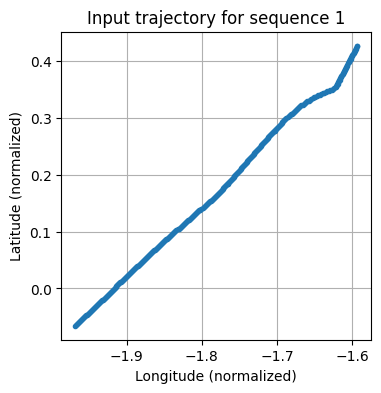

In [36]:
# Load the batch
batch = torch.load("sample_batch.pt")
X = batch["X"]  # shape: [B, T, F]
y = batch["y"]  # shape: [B, T, F]

print("X shape:", X.shape)
print("y shape:", y.shape)

# Assume feature 0 = Latitude, 1 = Longitude (adjust if needed)
lat_idx, lon_idx = 0, 1

# 2) Quick sanity stats
print("\nLat/Lon stats (X):")
print("  lat min/max:", X[:, :, lat_idx].min().item(), X[:, :, lat_idx].max().item())
print("  lon min/max:", X[:, :, lon_idx].min().item(), X[:, :, lon_idx].max().item())

# 3) Plot one example trajectory (input X[0])
seq_id = 1
seq = X[seq_id].cpu()

plt.figure(figsize=(4, 4))
plt.plot(seq[:, lon_idx], seq[:, lat_idx], marker=".", linestyle="-", linewidth=1)
plt.xlabel("Longitude (normalized)")
plt.ylabel("Latitude (normalized)")
plt.title(f"Input trajectory for sequence {seq_id}")
plt.grid(True)
plt.show()

In [37]:
from lstm_model import LSTMModel
input_size_base = 2
input_size_8 = 8 
hidden_size = 128
num_layers = 3 
output_size_base = 2
output_size_8 = 8 
dropout = 0.2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_base = LSTMModel(input_size_base, hidden_size, num_layers, output_size_base, dropout).to(device)
model_8 = LSTMModel(input_size_8, hidden_size, num_layers, output_size_8, dropout).to(device)

FEATURES_BASE = [
    'Latitude', 'Longitude']
FEATURES_8 = [
    'Latitude', 'Longitude', 'SOG', 'COG', 'Latitude_known', 'Longitude_known', 'SOG_known', 'COG_known'

]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [38]:
def rolling_forecast_lstm_batch_with_mask(model, batch_X, steps=300, device=device, FEATURES=FEATURES_BASE):
    model.eval()
    batch_X = batch_X.to(device)
    preds = []

    # global FEATURES has length 8, but the model output might not
    with torch.no_grad():
        input_seq = batch_X.clone()
        for _ in range(steps):
            out = model(input_seq)          # (B, seq_len, F)
            next_point = out[:, -1, :]      # (B, F)
            num_features = next_point.shape[-1]

            # only keep known-flag indices that are < num_features
            known_idx = [
                i for i, f in enumerate(FEATURES)
                if f.endswith("_known") and i < num_features
            ]
            if known_idx:
                next_point[:, known_idx] = 0.0

            preds.append(next_point.cpu().numpy())
            next_point_expanded = next_point.unsqueeze(1)  # (B,1,F)
            input_seq = torch.cat(
                [input_seq[:, 1:, :], next_point_expanded], dim=1
            )
    return np.stack(preds, axis=1)  # (B, steps, F)

## Basemodel: Lat  / long

In [39]:
scaler = joblib.load("scaler_with_mask.joblib")
state_dict = torch.load("models/best_lstm_model_Latitude_Longitude.pth", map_location=device)
model_base.load_state_dict(state_dict)
model_base.eval()

batch = torch.load("sample_batch.pt")
X_full = batch["X"]   # (B, T, 8)
y_full = batch["y"]   # (B, T, 8)

lat_idx, lon_idx = 0, 1  # adjust if needed

X = X_full[:, :, [lat_idx, lon_idx]]   # (B, T, 2)
y = y_full[:, :, [lat_idx, lon_idx]]   # (B, T, 2)

device = next(model_base.parameters()).device



# Stack predictions to get final array: (B, steps, model_output_features)
y_pred_full = rolling_forecast_lstm_batch_with_mask(model_base, X, steps=300, device=device, FEATURES=FEATURES_BASE)

robust_scaler = scaler[0]
feature_list  = scaler[1]

c:\Users\egk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


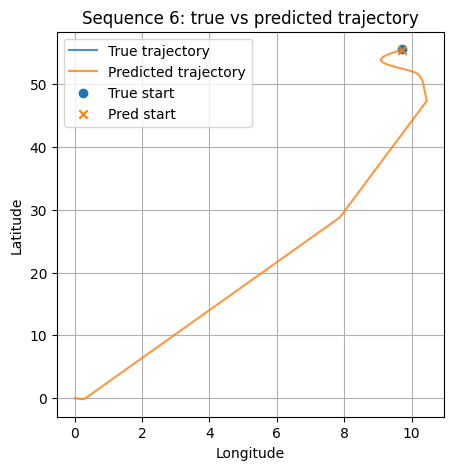

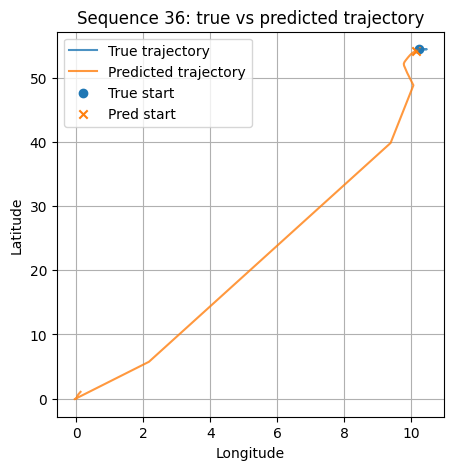

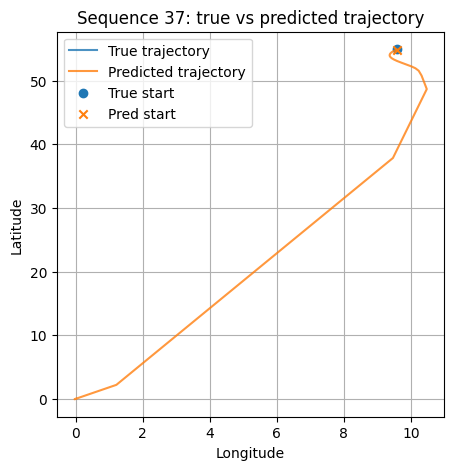

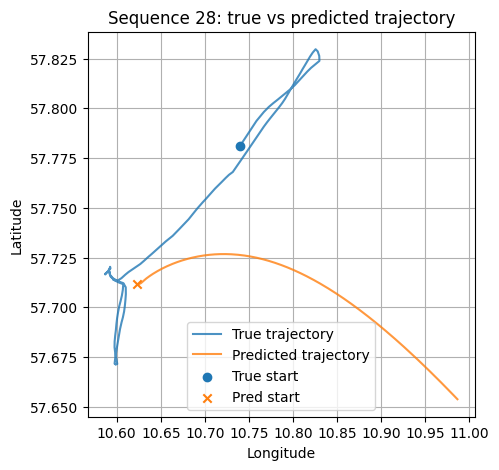

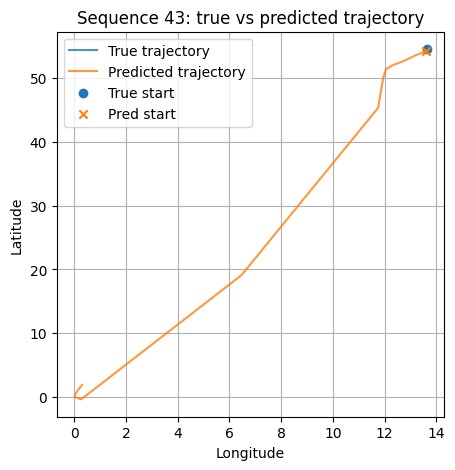

In [40]:
lat_idx, lon_idx = 0, 1
scaled_idx = [0, 1, 2, 3]   # Latitude, Longitude, SOG, COG

np.random.seed(100)
example_ids = np.random.choice(50, size=5, replace=False)
example_ids = example_ids.tolist()

for i in example_ids:
    y_true_seq_scaled = y_full[i]       # (T, 8)
    y_pred_seq_scaled = np.hstack([y_pred_full[i], y_pred_full[i]])  # (T, 8)

    y_true_unscaled = robust_scaler.inverse_transform(y_true_seq_scaled[:, :4])

    y_pred_unscaled = robust_scaler.inverse_transform(y_pred_seq_scaled[:, :4])

    true_lat = y_true_unscaled[:, lat_idx]
    true_lon = y_true_unscaled[:, lon_idx]
    pred_lat = y_pred_unscaled[:, lat_idx]
    pred_lon = y_pred_unscaled[:, lon_idx]

    plt.figure(figsize=(5, 5))
    plt.plot(true_lon, true_lat, label="True trajectory", alpha=0.8)
    plt.plot(pred_lon, pred_lat, label="Predicted trajectory", alpha=0.8)

    plt.scatter(true_lon[0], true_lat[0], marker="o", label="True start")
    plt.scatter(pred_lon[0], pred_lat[0], marker="x", label="Pred start")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Sequence {i}: true vs predicted trajectory")
    plt.legend()
    plt.grid(True)
    plt.show()


## 8-feature Model

In [41]:
scaler = joblib.load("scaler_with_mask.joblib")
state_dict = torch.load("models/best_lstm_model_Latitude_Longitude_SOG_COG_SOG_known_COG_known_Latitude_known_Longitude_known.pth", map_location=device)
model_8.load_state_dict(state_dict)
model_8.eval()

batch = torch.load("sample_batch.pt")
X_full = batch["X"]   # (B, T, 8)
y_full = batch["y"]   # (B, T, 8)

lat_idx, lon_idx = 0, 1  # adjust if needed

X = X_full.clone()  # (B, T, 2)
y = y_full.clone()  # (B, T, 2)

device = next(model_8 .parameters()).device

# Get predictions from 8-feature model
y_pred_full = rolling_forecast_lstm_batch_with_mask(model_8, X, steps=300, device=device, FEATURES=FEATURES_8)

robust_scaler = scaler[0]   # this is the actual RobustScaler
feature_list  = scaler[1]   # probably ["Latitude", "Longitude", ...]

c:\Users\egk\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator RobustScaler from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


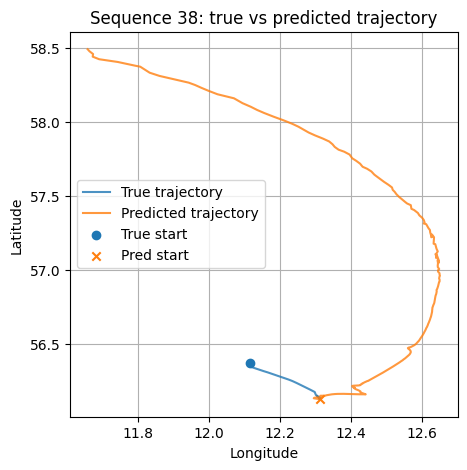

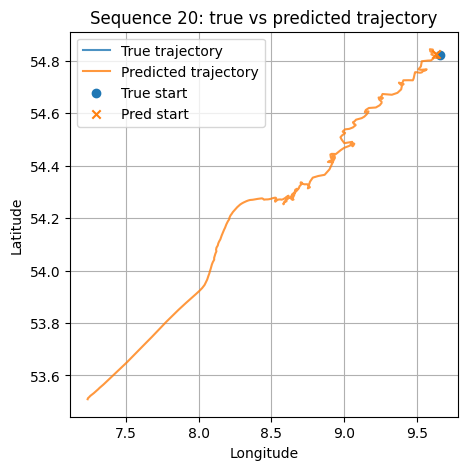

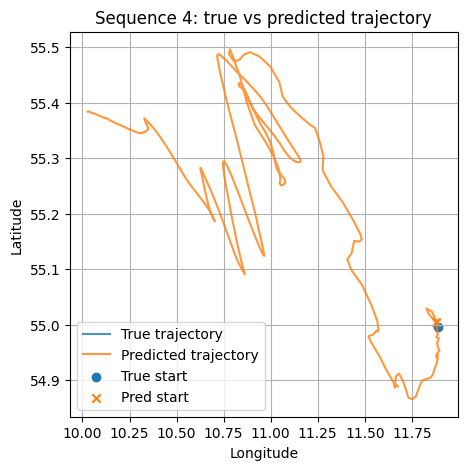

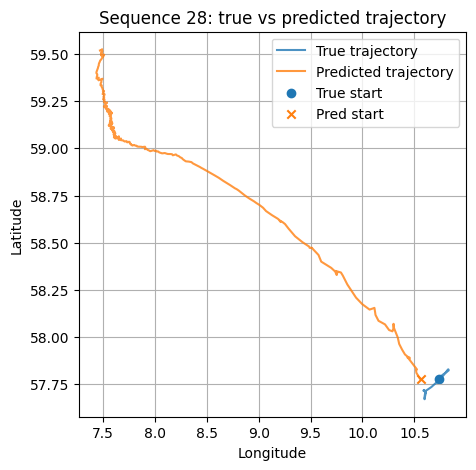

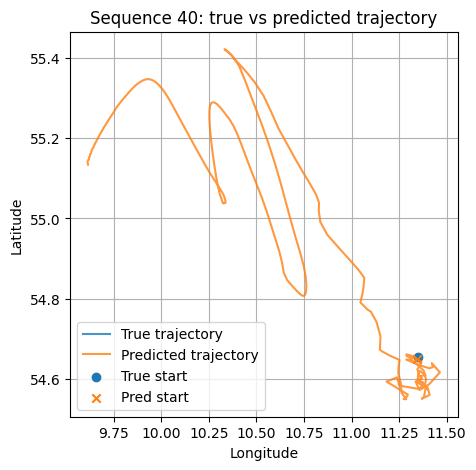

In [42]:
lat_idx, lon_idx = 0, 1
scaled_idx = [0, 1, 2, 3]   # Latitude, Longitude, SOG, COG

np.random.seed(60)
example_ids = np.random.choice(50, size=5, replace=False)
example_ids = example_ids.tolist()

for i in example_ids:
    y_true_seq_scaled = y_full[i]       # (T, 8)
    y_pred_seq_scaled = np.hstack([y_pred_full[i], y_pred_full[i]])  # (T, 8)

    y_true_unscaled = robust_scaler.inverse_transform(y_true_seq_scaled[:, :4])

    y_pred_unscaled = robust_scaler.inverse_transform(y_pred_seq_scaled[:, :4])

    true_lat = y_true_unscaled[:, lat_idx]
    true_lon = y_true_unscaled[:, lon_idx]
    pred_lat = y_pred_unscaled[:, lat_idx]
    pred_lon = y_pred_unscaled[:, lon_idx]

    plt.figure(figsize=(5, 5))
    plt.plot(true_lon, true_lat, label="True trajectory", alpha=0.8)
    plt.plot(pred_lon, pred_lat, label="Predicted trajectory", alpha=0.8)

    plt.scatter(true_lon[0], true_lat[0], marker="o", label="True start")
    plt.scatter(pred_lon[0], pred_lat[0], marker="x", label="Pred start")

    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(f"Sequence {i}: true vs predicted trajectory")
    plt.legend()
    plt.grid(True)
    plt.show()


## Results of base model (2 features)

Threshold file keys: ['mse_lat_thr', 'mse_lon_thr', 'mean_lat', 'mean_lon', 'std_lat', 'std_lon', 'K_SIGMA', 'STEPS']
K_SIGMA: 3.0 STEPS: 30
Rows: 383970
Unique (batch, sample): 12799
Overall anomaly rate (any coord, any step): 0.014795426726046305


step_ahead
1     0.002344
2     0.012814
3     0.002813
4     0.014454
5     0.008126
6     0.003282
7     0.000703
8     0.001406
9     0.004610
10    0.007657
11    0.010470
12    0.009688
13    0.005469
14    0.018595
15    0.019923
16    0.007110
17    0.007110
18    0.006172
19    0.024533
20    0.024924
21    0.025783
22    0.026252
23    0.027033
24    0.027424
25    0.027658
26    0.028127
27    0.028127
28    0.026799
29    0.023517
30    0.010938
Name: anom_any, dtype: float64

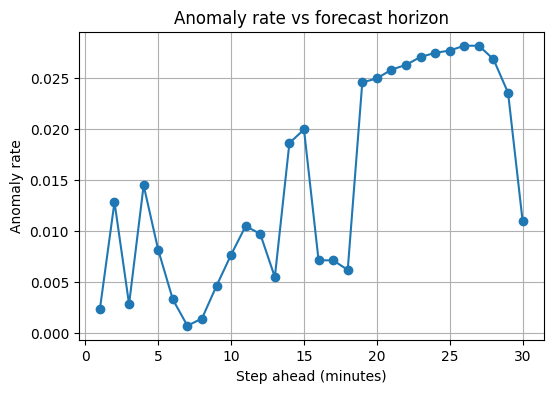

In [43]:
PROJECT_ROOT = Path.cwd()  # or set explicitly if needed
RES_DIR = PROJECT_ROOT

thr_path = RES_DIR / "model_results_base/anomaly/thresholds_base.npz"
parquet_path = RES_DIR / "model_results_base/anomaly/anomalies_steps_30.parquet"

# Load thresholds
thr = np.load(thr_path)
print("Threshold file keys:", thr.files)

mse_lat_thr = thr["mse_lat_thr"]
mse_lon_thr = thr["mse_lon_thr"]
mean_lat = thr["mean_lat"]
mean_lon = thr["mean_lon"]
std_lat = thr["std_lat"]
std_lon = thr["std_lon"]
K_SIGMA = float(thr["K_SIGMA"])
STEPS = int(thr["STEPS"])

print("K_SIGMA:", K_SIGMA, "STEPS:", STEPS)

# Load anomaly table
df = pd.read_parquet(parquet_path)
print("Rows:", len(df))
print("Unique (batch, sample):", df[["batch_idx", "sample_idx"]].drop_duplicates().shape[0])

print("Overall anomaly rate (any coord, any step):", df["anom_any"].mean())

# per-step anomaly rates
step_stats = df.groupby("step_ahead")["anom_any"].mean()
display(step_stats)

plt.figure(figsize=(6,4))
step_stats.plot(marker="o")
plt.xlabel("Step ahead (minutes)")
plt.ylabel("Anomaly rate")
plt.title("Anomaly rate vs forecast horizon")
plt.grid(True)
plt.show()


## Statistical results - 2-feature model

In [44]:
#For conversion to from mse to km 
KM_PER_DEG_LAT = 111.32

#Ref Latitude is based on the data being in Danish waters
REF_DEG_LAT = 56.0
KM_PER_DEG_LON = KM_PER_DEG_LAT * np.cos(np.deg2rad(REF_DEG_LAT))

print("Mean MSE for latitude: ", f"{df['mse_lat'].mean():.2e}")
print("Standard Deviation MSE for latitude: ", f"{df['mse_lat'].std():.2e}")
print("RMSE latitude in km: ", f"{(df['mse_lat'].mean()**0.5) * KM_PER_DEG_LAT:.2e}")
print("\n")
print("Mean MSE for longitude: ", f"{df['mse_lon'].mean():.2e}")
print("Standard Deviation MSE for longitude: ", f"{df['mse_lon'].std():.2e}")
print("RMSE longitude in km:   ", f"{(df['mse_lon'].mean()**0.5) * KM_PER_DEG_LON:.2e}")
print("\n\n")
#For time step 1
t1_lat = df[df['step_ahead'] == 1]['mse_lat']
print("Mean MSE for latitude at time step 1: ", f"{t1_lat.mean():.2e}")
print("Standard Deviation MSE for latitude at time step 1: ", f"{t1_lat.std():.2e}")
print("RMSE latitude in km: ", f"{(t1_lat.mean()**0.5) * KM_PER_DEG_LAT:.2e}")
print("\n")
t1_lon = df[df['step_ahead'] == 1]['mse_lon']
print("Mean MSE for longitude at time step 1: ", f"{t1_lon.mean():.2e}")
print("Standard Deviation MSE for longitude at time step 1: ", f"{t1_lon.std():.2e}")
print("RMSE longitude in km:   ", f"{(t1_lon.mean()**0.5) * KM_PER_DEG_LON:.2e}")
print("\n\n")

#For time step 30 
t30_lat = df[df['step_ahead'] == 30]['mse_lat']
print("Mean MSE for latitude at time step 30: ", f"{t30_lat.mean():.2e}")
print("Standard Deviation MSE for latitude at time step 30: ", f"{t30_lat.std():.2e}")
print("RMSE latitude in km: ", f"{(t30_lat.mean()**0.5) * KM_PER_DEG_LAT:.2e}")
print("\n")
t30_lon = df[df['step_ahead'] == 30]['mse_lon']
print("Mean MSE for longitude at time step 30: ", f"{t30_lon.mean():.2e}")
print("Standard Deviation MSE for longitude at time step 30: ", f"{t30_lon.std():.2e}")
print("RMSE longitude in km:   ", f"{(t30_lon.mean()**0.5) * KM_PER_DEG_LON:.2e}")
print("\n\n")

#Relative differences between time step 1 and 30
print("Relative difference in mean MSE for latitude between step 1 and 30: ", 
      round((t30_lat.mean() - t1_lat.mean()) / t1_lat.mean() * 100,1), "%")
print("Relative difference in mean MSE for longitude between step 1 and 30: ", 
      round((t30_lon.mean() - t1_lon.mean()) / t1_lon.mean() * 100, 1), "%")

Mean MSE for latitude:  8.42e-04
Standard Deviation MSE for latitude:  5.10e-03
RMSE latitude in km:  3.23e+00


Mean MSE for longitude:  2.33e-03
Standard Deviation MSE for longitude:  1.34e-01
RMSE longitude in km:    3.00e+00



Mean MSE for latitude at time step 1:  9.68e-05
Standard Deviation MSE for latitude at time step 1:  4.30e-04
RMSE latitude in km:  1.10e+00


Mean MSE for longitude at time step 1:  1.15e-04
Standard Deviation MSE for longitude at time step 1:  2.73e-04
RMSE longitude in km:    6.68e-01



Mean MSE for latitude at time step 30:  1.99e-03
Standard Deviation MSE for latitude at time step 30:  7.21e-03
RMSE latitude in km:  4.96e+00


Mean MSE for longitude at time step 30:  4.84e-03
Standard Deviation MSE for longitude at time step 30:  1.64e-01
RMSE longitude in km:    4.33e+00



Relative difference in mean MSE for latitude between step 1 and 30:  1950.7 %
Relative difference in mean MSE for longitude between step 1 and 30:  4109.7 %


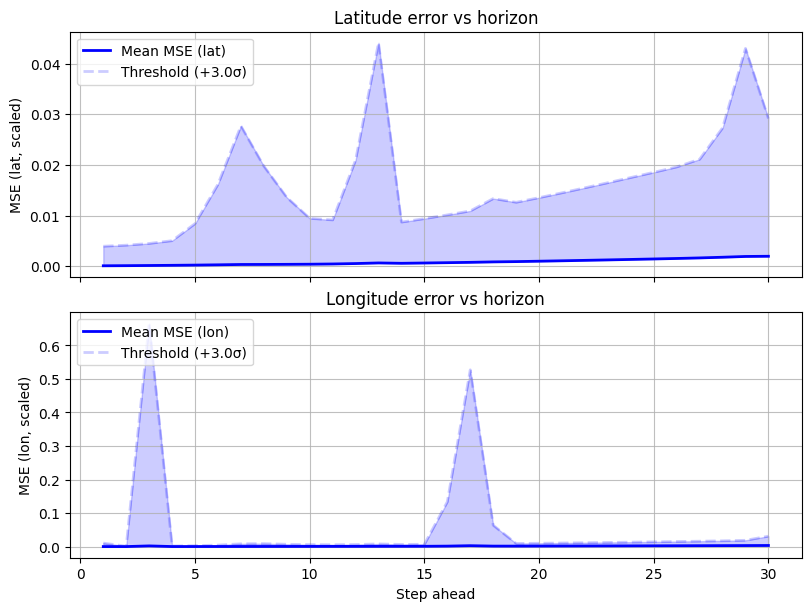

In [45]:

steps = np.arange(1, STEPS + 1)

lat_thr = mean_lat + K_SIGMA * std_lat
lon_thr = mean_lon + K_SIGMA * std_lon

fig, axes = plt.subplots(
    nrows=2, ncols=1, sharex=True, figsize=(8, 6), constrained_layout=True
)

# Latitude 
ax = axes[0]
ax.plot(steps, mean_lat, linewidth=2, label="Mean MSE (lat)", color="blue")
ax.plot(steps, lat_thr, linestyle="--", linewidth=2, label=f"Threshold (+{K_SIGMA}σ)", color = "blue", alpha=0.2)
ax.fill_between(steps, mean_lat, lat_thr, alpha=0.2, color="blue")

ax.set_ylabel("MSE (lat, scaled)")
ax.set_title("Latitude error vs horizon")
ax.grid(True, alpha=0.8)
ax.legend(loc="upper left")

# Longitude
ax = axes[1]
ax.plot(steps, mean_lon, linewidth=2, label="Mean MSE (lon)", color="blue")
ax.plot(steps, lon_thr, linestyle="--", linewidth=2, label=f"Threshold (+{K_SIGMA}σ)", color = "blue", alpha=0.2)
ax.fill_between(steps, mean_lon, lon_thr, alpha=0.2, color="blue")

ax.set_xlabel("Step ahead")
ax.set_ylabel("MSE (lon, scaled)")
ax.set_title("Longitude error vs horizon")
ax.grid(True, alpha = 0.8)
ax.legend(loc="upper left")

plt.show()


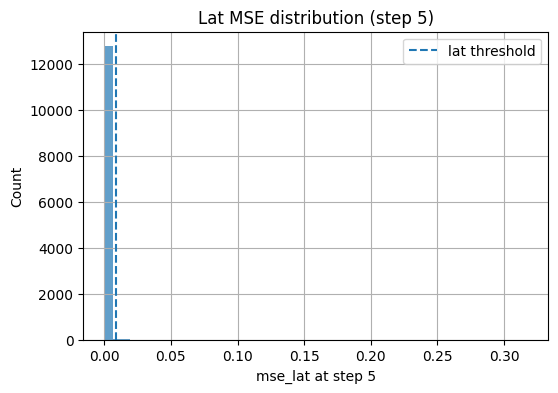

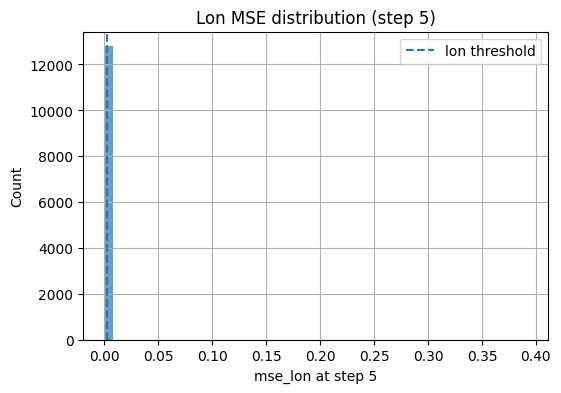

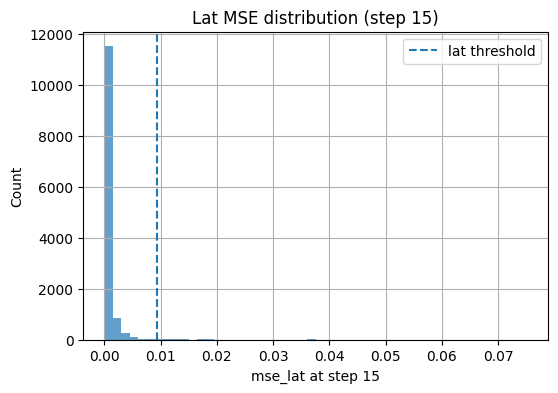

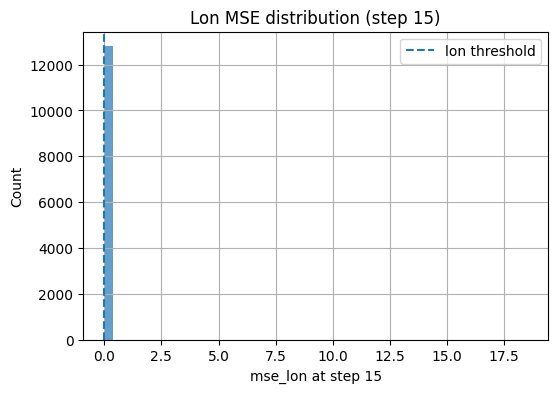

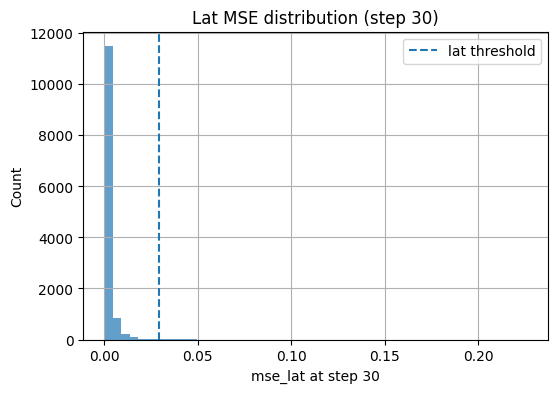

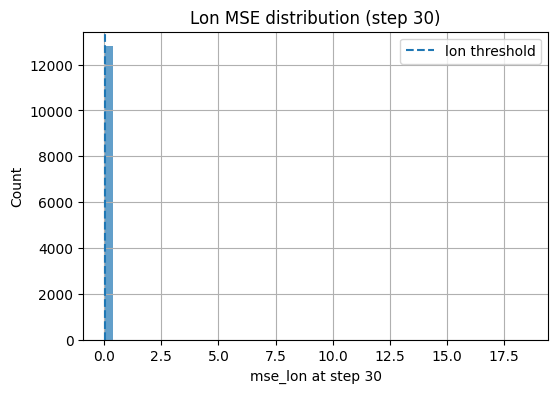

In [46]:
timesteps_to_check = [5, 15, 30]

for t in timesteps_to_check:
    subset = df[df["step_ahead"] == t]

    plt.figure(figsize=(6,4))
    subset["mse_lat"].hist(bins=50, alpha=0.7)
    plt.axvline(mse_lat_thr[t-1], linestyle="--", label="lat threshold")
    plt.xlabel(f"mse_lat at step {t}")
    plt.ylabel("Count")
    plt.title(f"Lat MSE distribution (step {t})")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    subset["mse_lon"].hist(bins=50, alpha=0.7)
    plt.axvline(mse_lon_thr[t-1], linestyle="--", label="lon threshold")
    plt.xlabel(f"mse_lon at step {t}")
    plt.ylabel("Count")
    plt.title(f"Lon MSE distribution (step {t})")
    plt.legend()
    plt.show()


## Plots of normal vs anomaly routes for 2-feature model

In [47]:
def sorted_by_suffix(paths):
    paths = list(paths)
    def key(p: Path):
        m = re.search(r"_(\d+)\.png$", p.name)
        return int(m.group(1)) if m else 10**12
    return sorted(paths, key=key)

def plot_image_grid(paths, title="", max_images=10, cols=5, figsize_per=(3.2, 3.2)):
    paths = list(paths)
    if max_images is None or max_images == "all":
        chosen = paths
    else:
        chosen = paths[:int(max_images)]

    if not chosen:
        print(f"[{title}] No images found.")
        return None

    n = len(chosen)
    cols = min(int(cols), n)
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols * figsize_per[0], rows * figsize_per[1]))
    axes = np.array(axes).reshape(-1)

    for ax, p in zip(axes, chosen):
        ax.imshow(mpimg.imread(p))
        ax.set_title(p.stem, fontsize=9)
        ax.axis("off")

    for ax in axes[len(chosen):]:
        ax.axis("off")

    fig.suptitle(title, y=1.02)
    fig.tight_layout()
    return fig

def plot_routes(folder, n_anomaly=10, n_normal=10, cols=5, shuffle=False, seed=0):
    folder = Path(folder)

    anomaly_paths = sorted_by_suffix(folder.glob("anomaly_route_*.png"))
    normal_paths  = sorted_by_suffix(folder.glob("normal_route_*.png"))

    if shuffle:
        import random
        rng = random.Random(seed)
        rng.shuffle(anomaly_paths)
        rng.shuffle(normal_paths)

    plot_image_grid(anomaly_paths, title="Anomaly routes", max_images=n_anomaly, cols=cols)
    plot_image_grid(normal_paths,  title="Normal routes",  max_images=n_normal,  cols=cols)
    plt.show()

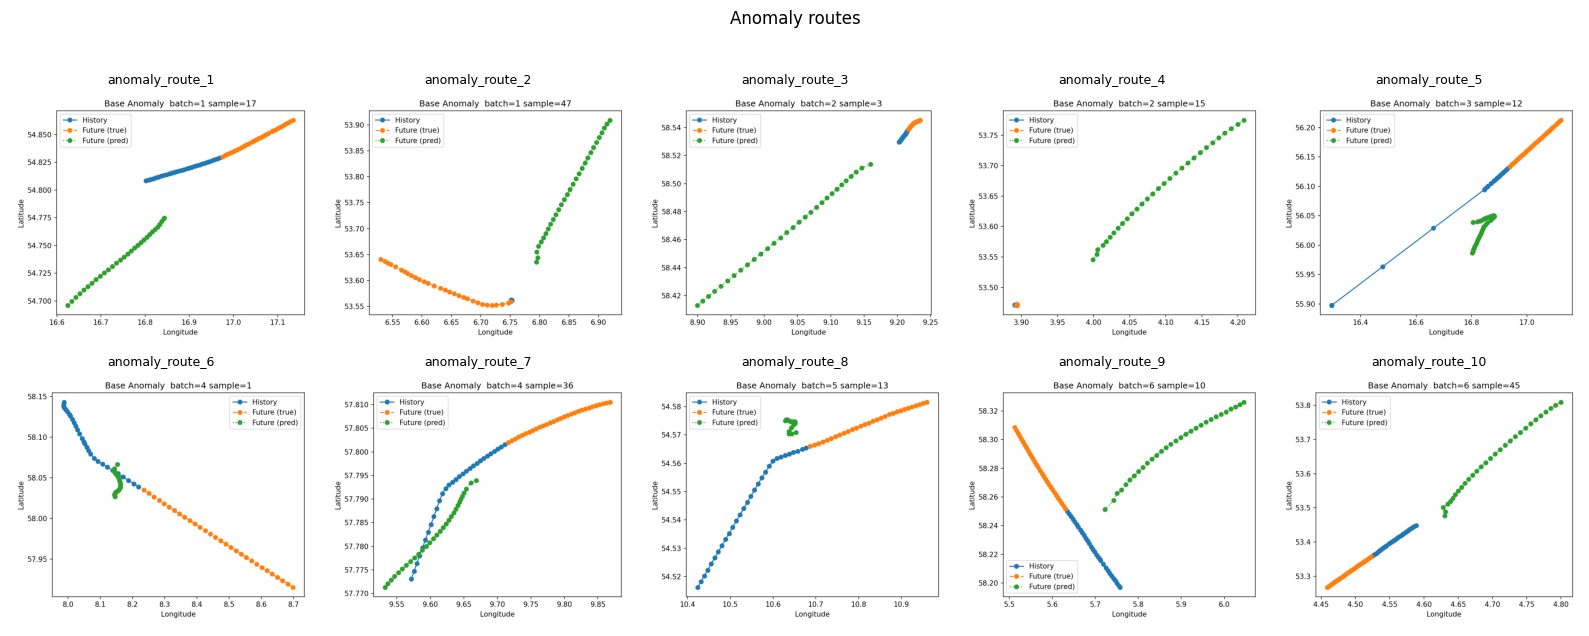

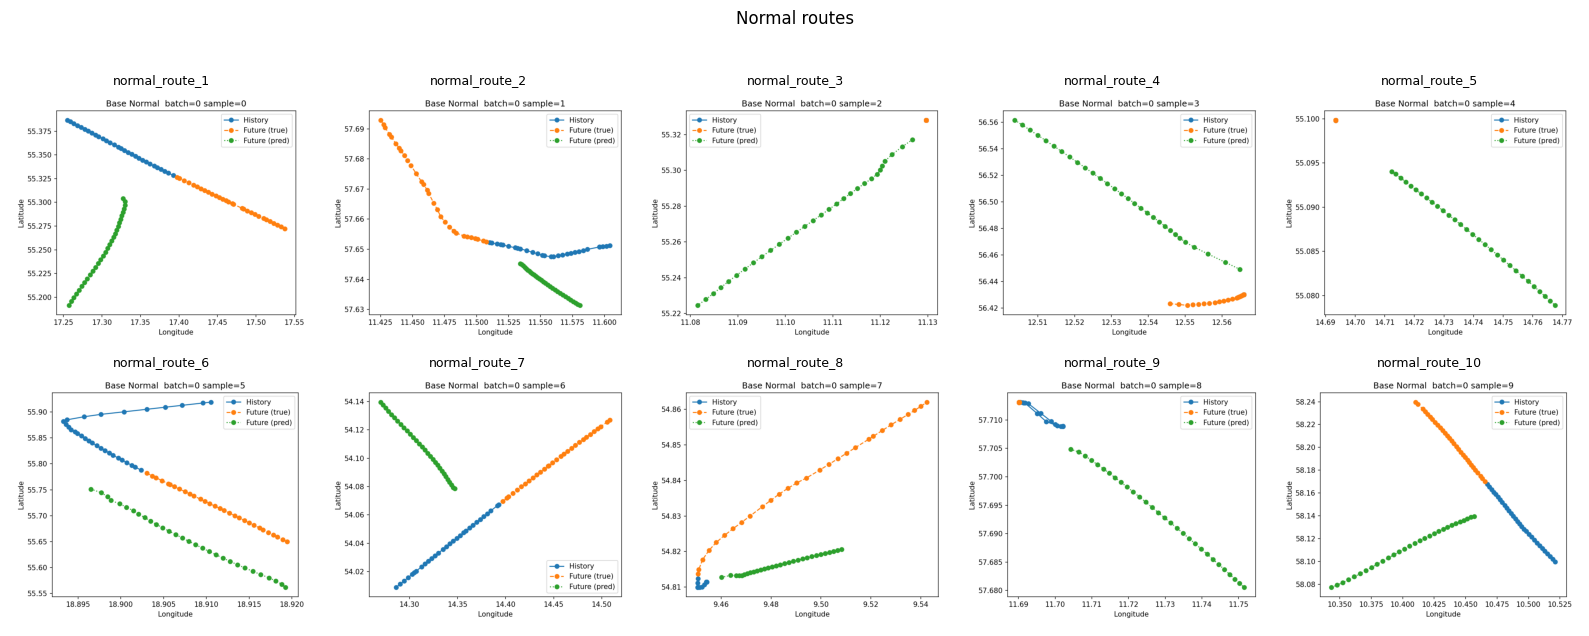

In [48]:
plot_routes("model_results_base/anomaly/plots_steps_30", n_anomaly="all", n_normal="all", cols=5)


## Results of advanced model (8 features)

Threshold file keys: ['mse_lat_thr', 'mse_lon_thr', 'mean_lat', 'mean_lon', 'std_lat', 'std_lon', 'K_SIGMA', 'STEPS']
K_SIGMA: 3.0 STEPS: 30
Rows: 383970
Unique (batch, sample): 12799
Overall anomaly rate (any coord, any step): 0.019019715081907442


step_ahead
1     0.021486
2     0.046566
3     0.017579
4     0.016564
5     0.014220
6     0.008516
7     0.004922
8     0.010938
9     0.017423
10    0.020861
11    0.021877
12    0.021799
13    0.019064
14    0.020080
15    0.018283
16    0.016798
17    0.016720
18    0.017814
19    0.018517
20    0.018361
21    0.019220
22    0.019611
23    0.018830
24    0.019142
25    0.019611
26    0.019611
27    0.021017
28    0.021877
29    0.021174
30    0.022111
Name: anom_any, dtype: float64

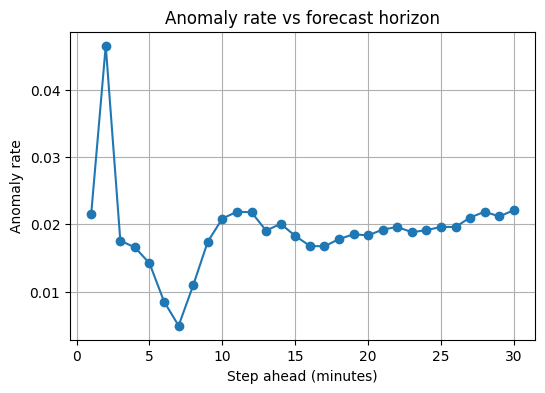

In [49]:
thr_path = RES_DIR / "model_results_8features/anomaly/thresholds_8features.npz"
parquet_path = RES_DIR / "model_results_8features/anomaly/anomalies_steps_30.parquet"

# Load thresholds
thr = np.load(thr_path)
print("Threshold file keys:", thr.files)

mse_lat_thr = thr["mse_lat_thr"]
mse_lon_thr = thr["mse_lon_thr"]
mean_lat = thr["mean_lat"]
mean_lon = thr["mean_lon"]
std_lat = thr["std_lat"]
std_lon = thr["std_lon"]
K_SIGMA = float(thr["K_SIGMA"])
STEPS = int(thr["STEPS"])

print("K_SIGMA:", K_SIGMA, "STEPS:", STEPS)

# Load anomaly table
df = pd.read_parquet(parquet_path)
print("Rows:", len(df))
print("Unique (batch, sample):", df[["batch_idx", "sample_idx"]].drop_duplicates().shape[0])

print("Overall anomaly rate (any coord, any step):", df["anom_any"].mean())

# per-step anomaly rates
step_stats = df.groupby("step_ahead")["anom_any"].mean()
display(step_stats)

plt.figure(figsize=(6,4))
step_stats.plot(marker="o")
plt.xlabel("Step ahead (minutes)")
plt.ylabel("Anomaly rate")
plt.title("Anomaly rate vs forecast horizon")
plt.grid(True)
plt.show()


## Statistical results - 8-feature model

In [50]:
#For conversion to from mse to km 
KM_PER_DEG_LAT = 111.32

#Ref Latitude is based on the data being in Danish waters
REF_DEG_LAT = 56.0
KM_PER_DEG_LON = KM_PER_DEG_LAT * np.cos(np.deg2rad(REF_DEG_LAT))

print("Mean MSE for latitude: ", f"{df['mse_lat'].mean():.2e}")
print("Standard Deviation MSE for latitude: ", f"{df['mse_lat'].std():.2e}")
print("RMSE latitude in km: ", f"{(df['mse_lat'].mean()**0.5) * KM_PER_DEG_LAT:.2e}")
print("\n")
print("Mean MSE for longitude: ", f"{df['mse_lon'].mean():.2e}")
print("Standard Deviation MSE for longitude: ", f"{df['mse_lon'].std():.2e}")
print("RMSE longitude in km:   ", f"{(df['mse_lon'].mean()**0.5) * KM_PER_DEG_LON:.2e}")
print("\n\n")
#For time step 1
t1_lat = df[df['step_ahead'] == 1]['mse_lat']
print("Mean MSE for latitude at time step 1: ", f"{t1_lat.mean():.2e}")
print("Standard Deviation MSE for latitude at time step 1: ", f"{t1_lat.std():.2e}")
print("RMSE latitude in km: ", f"{(t1_lat.mean()**0.5) * KM_PER_DEG_LAT:.2e}")
print("\n")
t1_lon = df[df['step_ahead'] == 1]['mse_lon']
print("Mean MSE for longitude at time step 1: ", f"{t1_lon.mean():.2e}")
print("Standard Deviation MSE for longitude at time step 1: ", f"{t1_lon.std():.2e}")
print("RMSE longitude in km:   ", f"{(t1_lon.mean()**0.5) * KM_PER_DEG_LON:.2e}")
print("\n\n")

#For time step 30 
t30_lat = df[df['step_ahead'] == 30]['mse_lat']
print("Mean MSE for latitude at time step 30: ", f"{t30_lat.mean():.2e}")
print("Standard Deviation MSE for latitude at time step 30: ", f"{t30_lat.std():.2e}")
print("RMSE latitude in km: ", f"{(t30_lat.mean()**0.5) * KM_PER_DEG_LAT:.2e}")
print("\n")
t30_lon = df[df['step_ahead'] == 30]['mse_lon']
print("Mean MSE for longitude at time step 30: ", f"{t30_lon.mean():.2e}")
print("Standard Deviation MSE for longitude at time step 30: ", f"{t30_lon.std():.2e}")
print("RMSE longitude in km:   ", f"{(t30_lon.mean()**0.5) * KM_PER_DEG_LON:.2e}")
print("\n\n")

#Relative differences between time step 1 and 30
print("Relative difference in mean MSE for latitude between step 1 and 30: ", 
      round((t30_lat.mean() - t1_lat.mean()) / t1_lat.mean() * 100,1), "%")
print("Relative difference in mean MSE for longitude between step 1 and 30: ", 
      round((t30_lon.mean() - t1_lon.mean()) / t1_lon.mean() * 100, 1), "%")

Mean MSE for latitude:  6.99e-02
Standard Deviation MSE for latitude:  1.24e-01
RMSE latitude in km:  2.94e+01


Mean MSE for longitude:  7.75e-02
Standard Deviation MSE for longitude:  1.82e-01
RMSE longitude in km:    1.73e+01



Mean MSE for latitude at time step 1:  6.37e-04
Standard Deviation MSE for latitude at time step 1:  3.48e-03
RMSE latitude in km:  2.81e+00


Mean MSE for longitude at time step 1:  1.31e-03
Standard Deviation MSE for longitude at time step 1:  3.49e-03
RMSE longitude in km:    2.26e+00



Mean MSE for latitude at time step 30:  2.15e-01
Standard Deviation MSE for latitude at time step 30:  2.18e-01
RMSE latitude in km:  5.16e+01


Mean MSE for longitude at time step 30:  2.16e-01
Standard Deviation MSE for longitude at time step 30:  2.93e-01
RMSE longitude in km:    2.89e+01



Relative difference in mean MSE for latitude between step 1 and 30:  33586.0 %
Relative difference in mean MSE for longitude between step 1 and 30:  16348.4 %


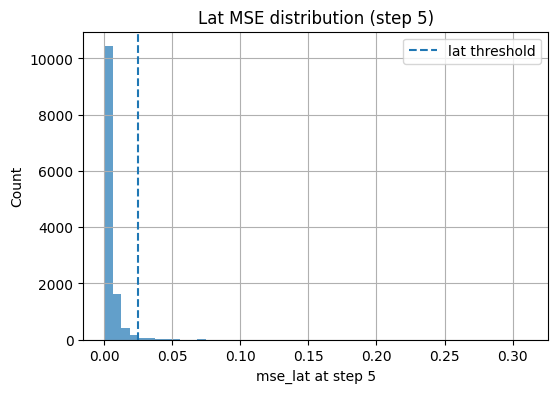

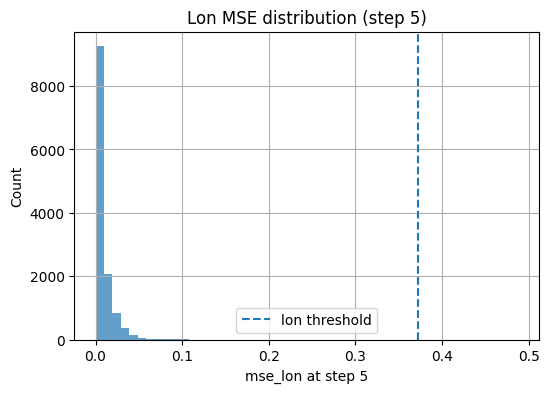

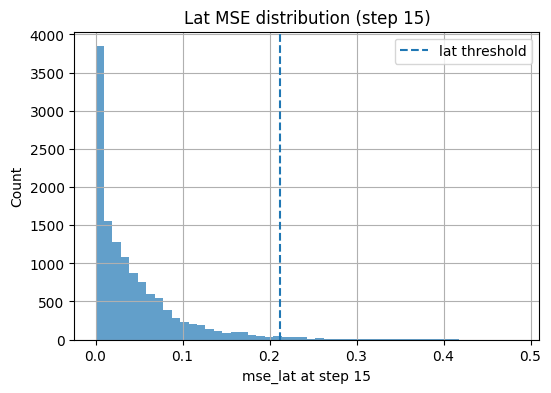

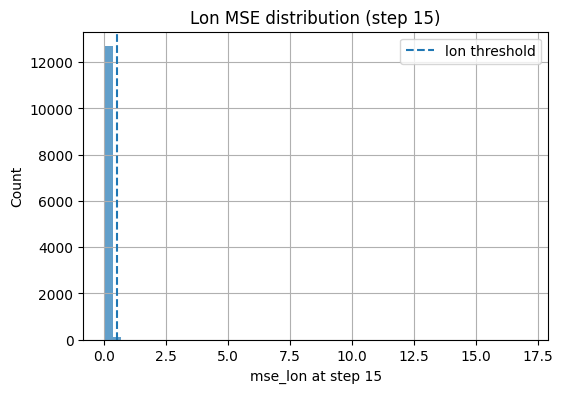

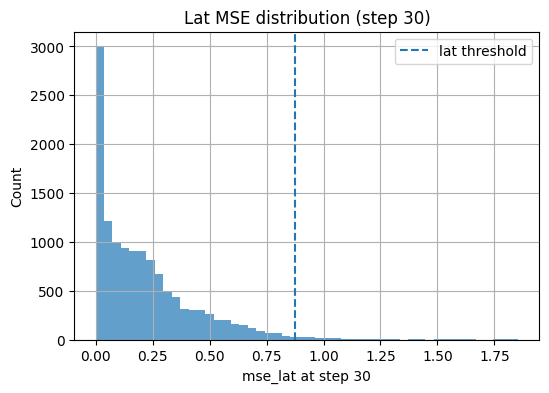

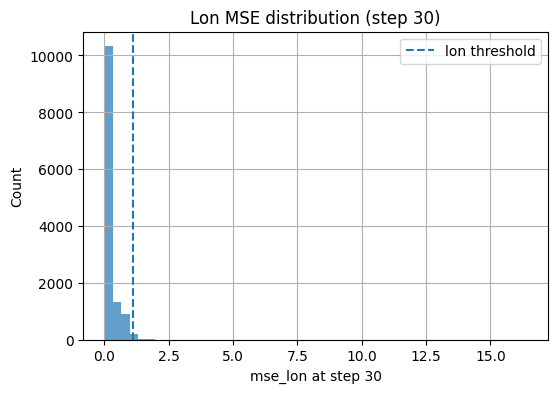

In [51]:
timesteps_to_check = [5, 15, 30]

for t in timesteps_to_check:
    subset = df[df["step_ahead"] == t]

    plt.figure(figsize=(6,4))
    subset["mse_lat"].hist(bins=50, alpha=0.7)
    plt.axvline(mse_lat_thr[t-1], linestyle="--", label="lat threshold")
    plt.xlabel(f"mse_lat at step {t}")
    plt.ylabel("Count")
    plt.title(f"Lat MSE distribution (step {t})")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6,4))
    subset["mse_lon"].hist(bins=50, alpha=0.7)
    plt.axvline(mse_lon_thr[t-1], linestyle="--", label="lon threshold")
    plt.xlabel(f"mse_lon at step {t}")
    plt.ylabel("Count")
    plt.title(f"Lon MSE distribution (step {t})")
    plt.legend()
    plt.show()


## Plots of normal vs anomaly routes for 8-feature model

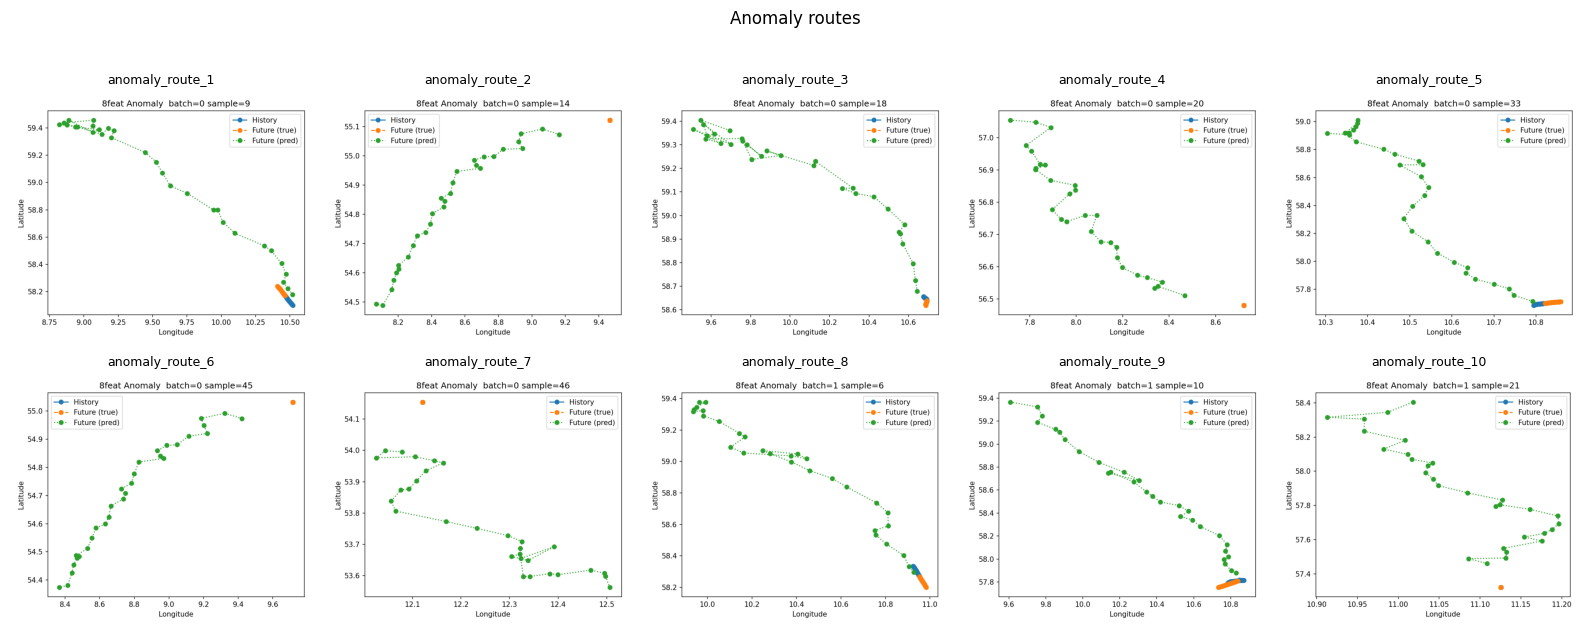

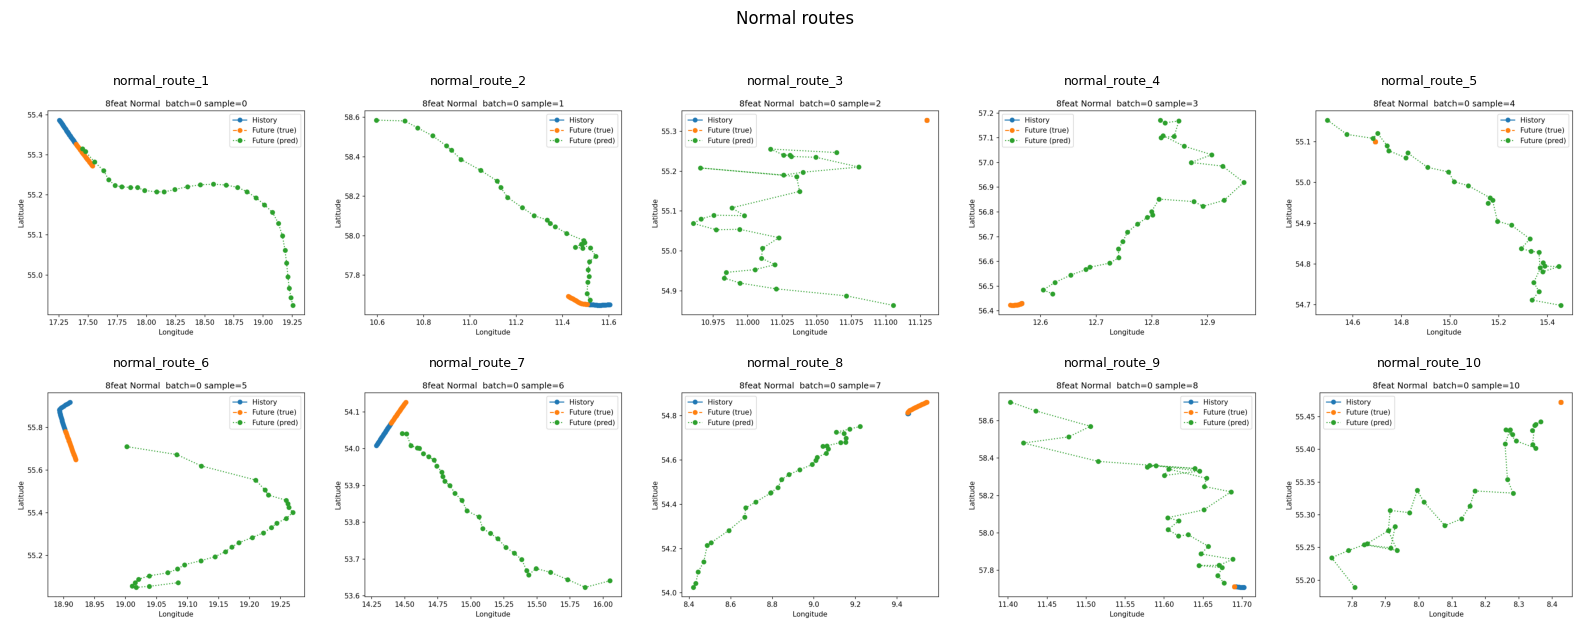

In [52]:
plot_routes("model_results_8features/anomaly/plots_steps_30", n_anomaly="all", n_normal="all", cols=5)
